Import Neccesary Libraries

In [1]:
from typing import Dict, List, Sequence
import whoosh
from whoosh.index import create_in
from whoosh.fields import *
import string
from whoosh.qparser import QueryParser ,OrGroup
from whoosh.analysis import StemmingAnalyzer,CharsetFilter,LanguageAnalyzer,RegexTokenizer,LowercaseFilter,StopFilter,StemFilter
from whoosh.support.charset import accent_map
import json
from whoosh.index import open_dir
from whoosh.query import Term, And ,Or
import os
from whoosh import scoring
import codecs
import pandas as pd
from nltk.corpus import stopwords
import nltk
from snowballstemmer import stemmer
from nltk.stem.isri import ISRIStemmer
import matplotlib.pyplot as plt
import numpy as np


create 2 directory

In [ ]:
os.mkdir("./DFQuery")
os.mkdir("./PrecisionInterpoli")

In [2]:
QueryList=["الأمن المعلوماتي","الفرضيات المعارضة","حوادث الطرق"]
NbrDoc={}
score= scoring.BM25F() 
Modal="BM25F"

# scoring.BM25F()    # scoring.TF_IDF()  # scoring.Frequency()


Class of whoosh 

In [3]:
Table={"File":[],QueryList[0]:[],QueryList[1]:[],QueryList[2]:[]}

class CRINDEXW:
    def __init__(self, IndexfileName, pathCorpus):
        self.FileName = IndexfileName
        self.PathCorpus = pathCorpus
        # my_analyzer = StemmingAnalyzer() | CharsetFilter(accent_map) | LowercaseFilter() | StopFilter(lang="en")
        # my_analyzer =StemmingAnalyzer(stemfn=ISRIStemmer().stem) | StopFilter(set(stopwords.words('arabic')))
        my_analyzer =StemmingAnalyzer(stemfn=stemmer('arabic').stemWord) | StopFilter(set(stopwords.words('arabic')))

        self.schema = Schema(title=ID(unique=True, stored=True), 
                            path=ID(stored=True), 
                            content=TEXT(stored=True,analyzer=my_analyzer))    
            
    def Create_index_File(self):
        if not os.path.exists(self.FileName):
            os.mkdir(self.FileName)
            index = create_in(self.FileName, self.schema)

    def __OpenIndex(self):
        return open_dir(self.FileName)

    def __CloseIndex(self):
        self.writer.commit()

    def __TypeOfencoding(self, PathFile):
        encodings = ['utf-8', 'windows-1256']  # add more
        for e in encodings:
            try:
                fh = codecs.open(PathFile, 'r', encoding=e)
                fh.read()
            except UnicodeDecodeError:
                continue
            else:
                return e

    def AddDocumentToInedx(self, NameFile, PathFile):
        os.chdir("/home/lounis/Documents/M2/RI/TP2/")
        EncType = self.__TypeOfencoding(PathFile)
        file=open(u""+PathFile+"", encoding=EncType).read()
        self.writer.add_document(title=NameFile,
                                 path=PathFile,
                                #  content=self.__Normalization_File(file))
                                 content=file)

    def AddAllDocumentToIndex(self):
        path = self.PathCorpus
        os.chdir(path)
        for file in os.listdir():
            if file.endswith(".txt"):
                file_path = f"{path}/{file}"
                self.AddDocumentToInedx(file, file_path)
 
    def Searcher(self,requete,TypeOfScoring,X):
        index = self.__OpenIndex()
        qp = QueryParser("content", schema=index.schema,
                         group=OrGroup).parse(requete)
        # qp = QueryParser("content", schema=index.schema).parse(requete)                 
        # WhooshResult={"Title":[],"content":[]}
        WhooshResult=[]
        print("--------------------------------",qp,"---------------------------------")

        with index.searcher(weighting=TypeOfScoring) as s:
            results = s.search(qp, limit=X)
            print(results)
            for c in results:
                WhooshResult.append(c['title'])
                # WhooshResult['Title'].append(c['title'])
                # WhooshResult['content'].append(c['content'])
            
            found = results.scored_length()
            print(found)

            if results.has_exact_length():
                print("Scored", found, "of exactly", len(results), "documents")
            else:
                low = results.estimated_min_length()
                high = results.estimated_length()
            print("Scored", found, "of between", low, "and", high, "documents")
            
            return WhooshResult,found
                
    def WriteInIndex(self):
        index = self.__OpenIndex()
        self.writer = index.writer()
        self.AddAllDocumentToIndex()
        self.__CloseIndex()


Create Schema and add all document to schema

In [4]:
objet=CRINDEXW("Index","/home/lounis/Documents/M2/RI/TP2/Corpus/Arabic")
# objet=CRINDEXW("Index","/home/lounis/Documents/M2/RI/TP2/Corpus/English")
objet.Create_index_File()
objet.WriteInIndex()

Import Manually Pertinant

In [5]:
Manually=pd.read_excel("./Result/RechercheManuelle.xlsx").set_index("Title")
ManuallyQueryFind={ QueryList[0]:{  "index":[i+1 for i in range(len(Manually[Manually.Q1==1].index.to_list()))],
                                    "File":Manually[Manually.Q1==1].index.to_list(),
                                    "pertinance":[]},
                    QueryList[1]:{  "index":[i+1 for i in range(len(Manually[Manually.Q2==1].index.to_list()))],
                                    "File":Manually[Manually.Q2==1].index.to_list(),
                                    "pertinance":[]},
                    QueryList[2]:{  "index":[i+1 for i in range(len(Manually[Manually.Q3==1].index.to_list()))],
                                    "File":Manually[Manually.Q3==1].index.to_list(),
                                    "pertinance":[]}}


In [6]:
print(len(ManuallyQueryFind[QueryList[0]]["File"]))
print(len(ManuallyQueryFind[QueryList[1]]["File"]))
print(len(ManuallyQueryFind[QueryList[2]]["File"]))



34
25
133


Verification The relevance of the document

In [7]:
def Pertinance(TablePertinance,ResultWhoosh,query):
    for File in  TablePertinance[query]["File"]:
        if File in ResultWhoosh:
            TablePertinance[query]["pertinance"].append(1)
        else:
            TablePertinance[query]["pertinance"].append(0)
    return TablePertinance
    


Function For Calculate Both of Precision AND Reminder 

In [8]:
def CPR(Data,NbrDocPer,query):
    Reminder=[]
    Precision=[]
    cpt=0
    for index in range(len(Data[query]["File"])):
        if(Data[query]["pertinance"][index]==0):
            Reminder.append(0)
            Precision.append(0)
        else:
            cpt=cpt+1;
            Reminder.append(round((cpt/len(Data[query]["File"])),3))
            Precision.append(round((cpt/(index+1)),3))

    return Reminder,Precision,cpt+1 

Function to Calculate Reminder And Precision AND FMesure For Each query

In [9]:
def C_RPFM(ManuallyQueryFind,QueryList):
    FMesure={QueryList[0]:0,QueryList[1]:0,QueryList[2]:0}
    print("F_Mesure")
    for query in QueryList:
        ManuallyQueryFind[query]['Reminder'],ManuallyQueryFind[query]['Precision'],cpt=CPR(ManuallyQueryFind,NbrDoc[query],query)
        F_Mes=0
        if(NbrDoc[query]!=0):
            P=round((cpt/len(ManuallyQueryFind[query]["File"])),3)
            # R=round((cpt/NbrDoc[query]))
            R=round((cpt/len(ManuallyQueryFind[query]['File'])),3)
            F_Mes=round(((2*P*R)/(P+R)),3)
        FMesure[query]=F_Mes
        print(query," ========> ",F_Mes)
    return FMesure


Calculate AVGPrec 

In [10]:
def Calcul_AVGPrec(Data,query,NbrDoc):
    AVG_Precision=0
    if (NbrDoc!=0):
        for index in range(len(Data[query]["File"])):
            if(Data[query]["pertinance"][index]!=0):
                AVG_Precision=AVG_Precision+Data[query]["Precision"][index]
        AVG_Precision=round((AVG_Precision/NbrDoc),3)
        
    print(query," -------> ",AVG_Precision)
    return AVG_Precision

Interpolated Precisions

In [11]:
def InterpoledPrecision(Rappel,Data,query):
    PrecInter=[0,0,0,0,0,0,0,0,0,0,0]
    index=0
    pos=0
    
    for i in range(len(Rappel)):
        index=0
        while index <= len(Data[query]["Precision"])-1:
            if (Rappel[i] <= Data[query]["Reminder"][index]):
                pos=index
                break
            else :
                pos= index
            index=index+1
        Rapp=max(list(Data[query]["Precision"][pos:(len(Data[query]["Precision"]))]))
        PrecInter[i]=Rapp
    return  PrecInter


Function to Plot  Interpolated Precision


In [12]:
def Plot(Dict_Inter,QueryList):
    fig, ax = plt.subplots()
    for query in QueryList:
        ax.plot(Dict_Inter["Rappel"]+[1.0,1.2], Dict_Inter["PreInt "+query]+[0,0],"o-",label=(query[::-1]))
        ax.legend()

    ax.set_xlabel("Reminder")
    ax.set_ylabel("Precision")
    plt.title("Plot Of Interpolated Precisions")
    plt.show() 

Calcul precesion au points donne

In [13]:
def Prec_Pos(Data,point):
    Prec={}
    for query in QueryList:
        Prec[query]=[]
        Prec[query].append (round((sum(Data[query]['Precision'][:point])/point),3))
    return Prec


            --------------------------Evaluation------------------------------------

Search Query with method scoring 

In [14]:
for query in QueryList: 
   Result,NbrDoc[query]=objet.Searcher(query,score,20)
   ManuallyQueryFind=Pertinance(ManuallyQueryFind,Result,query) 


-------------------------------- (content:امن OR content:معلومات) ---------------------------------
<Top 14 Results for Or([Term('content', 'امن'), Term('content', 'معلومات')]) runtime=0.0007076490001054481>
14
Scored 14 of between 14 and 14 documents
-------------------------------- (content:فرض OR content:معارض) ---------------------------------
<Top 20 Results for Or([Term('content', 'فرض'), Term('content', 'معارض')]) runtime=0.0009581479971529916>
20
Scored 20 of between 3 and 23 documents
-------------------------------- (content:حوادث OR content:طرق) ---------------------------------
<Top 20 Results for Or([Term('content', 'حوادث'), Term('content', 'طرق')]) runtime=0.0031311679995269515>
20
Scored 20 of between 5 and 124 documents


Calculate Reminder And Precision AND FMesure 

In [15]:
C_RPFM(ManuallyQueryFind,QueryList)

F_Mesure
الأمن المعلوماتي  ========>  0.441
الفرضيات المعارضة  ========>  0.84
حوادث الطرق  ========>  0.158


{'الأمن المعلوماتي': 0.441, 'الفرضيات المعارضة': 0.84, 'حوادث الطرق': 0.158}

Calculate AVG_Precision For each query

In [16]:
AVGQueryList={}
MAP=0
print("AVGPrec")
for query in QueryList:
    AVGQueryList[query]=Calcul_AVGPrec(ManuallyQueryFind,query,NbrDoc[query])
    MAP=MAP+AVGQueryList[query]
MAP=round((MAP/len(QueryList)),3)
print("MAP = ",MAP)

AVGPrec
الأمن المعلوماتي  ------->  0.382
الفرضيات المعارضة  ------->  0.987
حوادث الطرق  ------->  0.205
MAP =  0.525


Calculate Interpolated For Each Query


In [17]:
Rappel=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
Dict_Inter={"Rappel":Rappel}
for query in QueryList:
    Dict_Inter["PreInt "+query]=InterpoledPrecision(Rappel,ManuallyQueryFind,query)


Plot 

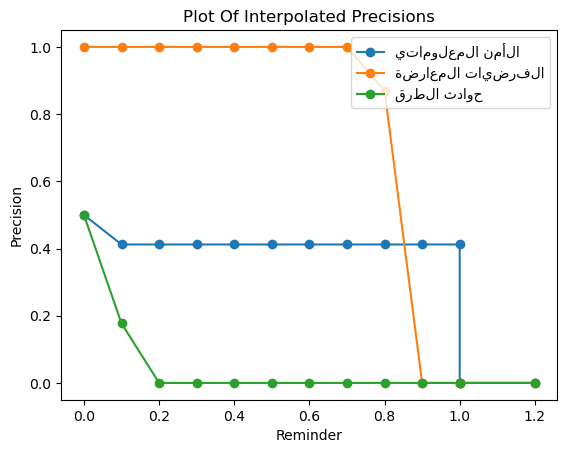

In [18]:
Plot(Dict_Inter,QueryList)
Dict_Inter=pd.DataFrame(Dict_Inter, index=Dict_Inter["Rappel"],
                                    columns=[   "PreInt "+QueryList[0],
                                                "PreInt "+QueryList[1],
                                                "PreInt "+QueryList[2]])
Dict_Inter.to_excel("./PrecisionInterpoli/InterpoleEvaluation"+Modal+".xlsx")

In [19]:
DFQ1=pd.DataFrame(ManuallyQueryFind[QueryList[0]],index=ManuallyQueryFind[QueryList[0]]["index"],columns=["File","pertinance","Reminder","Precision"])
DFQ1.to_excel("./DFQuery/DFQ1"+Modal+".xlsx")
DFQ2=pd.DataFrame(ManuallyQueryFind[QueryList[1]],index=ManuallyQueryFind[QueryList[1]]["index"],columns=["File","pertinance","Reminder","Precision"])
DFQ2.to_excel("./DFQuery/DFQ2"+Modal+".xlsx")
DFQ3=pd.DataFrame(ManuallyQueryFind[QueryList[2]],index=ManuallyQueryFind[QueryList[2]]["index"],columns=["File","pertinance","Reminder","Precision"])
DFQ3.to_excel("./DFQuery/DFQ3"+Modal+".xlsx")


Calcule da précision aux points (P5, P10, P15, P20)

In [20]:
P5=Prec_Pos(ManuallyQueryFind,5)
P10=Prec_Pos(ManuallyQueryFind,10)
P15=Prec_Pos(ManuallyQueryFind,15)
P20=Prec_Pos(ManuallyQueryFind,20)

In [21]:
print("P5",P5)
print("P10",P10)
print("P15",P15)
print("P20",P20)

P5 {'الأمن المعلوماتي': [0.2], 'الفرضيات المعارضة': [1.0], 'حوادث الطرق': [0.1]}
P10 {'الأمن المعلوماتي': [0.15], 'الفرضيات المعارضة': [1.0], 'حوادث الطرق': [0.117]}
P15 {'الأمن المعلوماتي': [0.122], 'الفرضيات المعارضة': [1.0], 'حوادث الطرق': [0.078]}
P20 {'الأمن المعلوماتي': [0.107], 'الفرضيات المعارضة': [0.9], 'حوادث الطرق': [0.083]}


            --------------------------Reformulation Automatique------------------------------------

Existing Words in All Querys

In [22]:
words={}
for query in QueryList:
    for word in query.split(" "):
        words[word]=[]
                #synset WordNet
words['الطرق']=["طَرِيق","سَبِيل","اِتِّجَاه", "جِهَة" ,"وِجْهَة","مدخل","شَارِع"]
words['حوادث']=["حصل","دار","جرى", "وقع" ,"حَادِثَة","حَدَث","حُصُول","حُدُوث"]
words['المعارضة']=["عَرَضَ","جَلَبَ","قَدَّمَ","أَظْهَرَ","عَرَضَ","صَوَّرَ","مَثَّلَ"]
words['الفرضيات']=["أَكَّدَ","فَرَضَ","أَصَابَ","وَجَّهَ"]
words['المعلوماتي']=["حَقِيقَة","مَعْلُومَة"]
words['الأمن']=["أَمْن","أَكَّدَ","ضَمِنَ","صَانَ","كَفَلَ"]

for key,value in words.items():
    words[key]=[stemmer("arabic").stemWord(word) for word in value]
QueryAWN=[  ' '.join(words['الأمن']+words['المعلوماتي']), 
            ' '.join(words['الفرضيات']+words['المعارضة']),
            ' '.join(words['حوادث']+words['الطرق'])]


Initialization DataFrame [FileName,Query1,Query2,Query3]  For AWN AND Search Query with method scoring


In [23]:
ManuallyQueryFindAWN={ QueryList[0]:{ "index":[i+1 for i in range(len(Manually[Manually.Q1==1].index.to_list()))],
                                       "File":Manually[Manually.Q1==1].index.to_list(),
                                       "pertinance":[]},
                    QueryList[1]:{     "index":[i+1 for i in range(len(Manually[Manually.Q2==1].index.to_list()))],
                                       "File":Manually[Manually.Q2==1].index.to_list(),
                                       "pertinance":[]},
                    QueryList[2]:{     "index":[i+1 for i in range(len(Manually[Manually.Q3==1].index.to_list()))],
                                       "File":Manually[Manually.Q3==1].index.to_list(),
                                       "pertinance":[]}}
NbrDocAWN={}

Searcher

In [24]:
i=0;
for query in QueryList:
   print(query)  
   Result2,NbrDocAWN[QueryAWN[i]]=objet.Searcher(QueryAWN[i],score,20)
   ManuallyQueryFindAWN=Pertinance(ManuallyQueryFindAWN,Result2,query) 
   i=i+1

الأمن المعلوماتي
-------------------------------- (content:امن OR content:اكد OR content:ضمن OR content:صان OR content:كفل OR content:حقيق OR content:معلوم) ---------------------------------
<Top 20 Results for Or([Term('content', 'امن'), Term('content', 'اكد'), Term('content', 'ضمن'), Term('content', 'صان'), Term('content', 'كفل'), Term('content', 'حقيق'), Term('content', 'معلوم')]) runtime=0.005904057001316687>
20
Scored 20 of between 8 and 116 documents
الفرضيات المعارضة
-------------------------------- (content:اكد OR content:فرض OR content:اصاب OR content:وجه OR content:عرض OR content:جلب OR content:قدم OR content:اظهر OR content:صور) ---------------------------------
<Top 20 Results for Or([Term('content', 'اكد'), Term('content', 'فرض'), Term('content', 'اصاب'), Term('content', 'وجه'), Term('content', 'عرض'), Term('content', 'جلب'), Term('content', 'قدم'), Term('content', 'اظهر'), Term('content', 'صور')]) runtime=0.00870121100160759>
20
Scored 20 of between 4 and 274 documents
حو

Calculate Reminder And Precision For Each query IN model ArabicWordNet

In [25]:
for query in QueryList:
    ManuallyQueryFindAWN[query]["Reminder"],ManuallyQueryFindAWN[query]["Precision"],cpt=CPR(ManuallyQueryFindAWN,NbrDoc[query],query)
    

Calculate  FMesure 

In [26]:
FMes2=C_RPFM(ManuallyQueryFindAWN,QueryList)


F_Mesure
الأمن المعلوماتي  ========>  0.235
الفرضيات المعارضة  ========>  0.4
حوادث الطرق  ========>  0.038


Calculate Average AND MAP

In [27]:
AVGQueryListAWN={}
MAP_AWN=0
print("AVG")
for query in QueryList:
    AVGQueryListAWN[query]=Calcul_AVGPrec(ManuallyQueryFindAWN,query,NbrDoc[query])
    MAP_AWN=MAP_AWN+AVGQueryListAWN[query]
MAP_AWN=round((MAP_AWN/len(QueryList)),3)
print("MAP_AWN = ",MAP_AWN)

AVG
الأمن المعلوماتي  ------->  0.151
الفرضيات المعارضة  ------->  0.135
حوادث الطرق  ------->  0.006
MAP_AWN =  0.097


Calculate Interpolated For Each Query

In [28]:
Rappel=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
Dict_InterAWN={"Rappel":Rappel}
for query in QueryList:
    Dict_InterAWN["PreInt "+query]=InterpoledPrecision(Rappel,ManuallyQueryFindAWN,query)


Plot of AWN

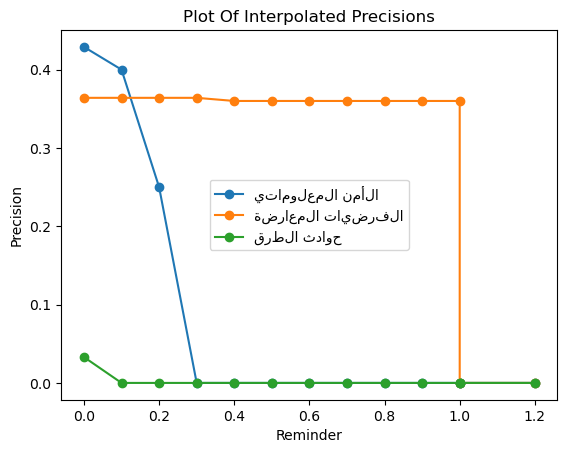

In [29]:
Plot(Dict_InterAWN,QueryList)
Dict_InterAWN=pd.DataFrame(Dict_InterAWN,index=Dict_InterAWN["Rappel"],columns=["PreInt "+QueryList[0],"PreInt "+QueryList[1],"PreInt "+QueryList[2]])
Dict_InterAWN.to_excel("./PrecisionInterpoli/InterpoleReformulation"+Modal+".xlsx")

In [30]:
DFQ1R=pd.DataFrame(ManuallyQueryFindAWN[QueryList[0]],index=ManuallyQueryFindAWN[QueryList[0]]["index"],columns=["File","pertinance","Reminder","Precision"])
DFQ1R.to_excel("./DFQuery/DFRQ1"+Modal+".xlsx")
DFQ2R=pd.DataFrame(ManuallyQueryFindAWN[QueryList[1]],index=ManuallyQueryFindAWN[QueryList[1]]["index"],columns=["File","pertinance","Reminder","Precision"])
DFQ2R.to_excel("./DFQuery/DFRQ2"+Modal+".xlsx")
DFQ3R=pd.DataFrame(ManuallyQueryFindAWN[QueryList[2]],index=ManuallyQueryFindAWN[QueryList[2]]["index"],columns=["File","pertinance","Reminder","Precision"])
DFQ3R.to_excel("./DFQuery/DFRQ3"+Modal+".xlsx")

In [31]:
P5AWN=Prec_Pos(ManuallyQueryFindAWN,5)
P10AWN=Prec_Pos(ManuallyQueryFindAWN,10)
P15AWN=Prec_Pos(ManuallyQueryFindAWN,15)
P20AWN=Prec_Pos(ManuallyQueryFindAWN,20)

In [32]:
print("P5",P5AWN)
print("P10",P10AWN)
print("P15",P15AWN)
print("P20",P20AWN)

P5 {'الأمن المعلوماتي': [0.05], 'الفرضيات المعارضة': [0.04], 'حوادث الطرق': [0.0]}
P10 {'الأمن المعلوماتي': [0.141], 'الفرضيات المعارضة': [0.053], 'حوادث الطرق': [0.0]}
P15 {'الأمن المعلوماتي': [0.094], 'الفرضيات المعارضة': [0.051], 'حوادث الطرق': [0.0]}
P20 {'الأمن المعلوماتي': [0.071], 'الفرضيات المعارضة': [0.082], 'حوادث الطرق': [0.0]}


        ---------------------Reformulation Automatique + Validation utilisateur--------------------------------

In [33]:
wordsv={}
wordsv['الطرق']=["طَرِيق","الطرق"]
wordsv['حوادث']=["حصل","دار","جرى", "وقع" ,"حَادِثَة","حَدَث","حُصُول","حُدُوث","حوادث"]
wordsv['المعارضة']=["المعارضة"]
wordsv['الفرضيات']=["الفرضيات"]
wordsv['المعلوماتي']=["مَعْلُومَة",'المعلوماتي']
wordsv['الأمن']=["ضَمِنَ","صَانَ","الأمن"]

In [34]:
for key,value in wordsv.items():
    wordsv[key]=[stemmer("arabic").stemWord(word) for word in value]
QueryAWNV=[  ' '.join(wordsv['الأمن']+wordsv['المعلوماتي']), 
            ' '.join(wordsv['الفرضيات']+wordsv['المعارضة']),
            ' '.join(wordsv['حوادث']+wordsv['الطرق'])]

In [35]:
NbrDocAWNV={}
ManuallyQueryFindAWNV={ QueryList[0]:{  "index":[i+1 for i in range(len(Manually[Manually.Q1==1].index.to_list()))],
                                    "File":Manually[Manually.Q1==1].index.to_list(),
                                    "pertinance":[]},
                    QueryList[1]:{  "index":[i+1 for i in range(len(Manually[Manually.Q2==1].index.to_list()))],
                                    "File":Manually[Manually.Q2==1].index.to_list(),
                                    "pertinance":[]},
                    QueryList[2]:{  "index":[i+1 for i in range(len(Manually[Manually.Q3==1].index.to_list()))],
                                    "File":Manually[Manually.Q3==1].index.to_list(),
                                    "pertinance":[]}}

Searcher

In [36]:
i=0;
for query in QueryList:
   Result,NbrDocAWNV[QueryAWNV[i]]=objet.Searcher(QueryAWNV[i],score,20)
   ManuallyQueryFindAWNV=Pertinance(ManuallyQueryFindAWNV,Result,query) 
   i=i+1

-------------------------------- (content:ضمن OR content:صان OR content:امن OR content:معلوم OR content:معلوما) ---------------------------------
<Top 20 Results for Or([Term('content', 'ضمن'), Term('content', 'صان'), Term('content', 'امن'), Term('content', 'معلوم'), Term('content', 'معلوما')]) runtime=0.007238623999000993>
20
Scored 20 of between 14 and 96 documents
-------------------------------- (content:فرض OR content:معارض) ---------------------------------
<Top 20 Results for Or([Term('content', 'فرض'), Term('content', 'معارض')]) runtime=0.002345974000490969>
20
Scored 20 of between 3 and 23 documents
-------------------------------- (content:حصل OR content:دار OR content:جر OR content:وقع OR content:حادث OR content:حدث OR content:حصول OR content:حدوث OR content:حوادث OR content:طريق OR content:طرق) ---------------------------------
<Top 20 Results for Or([Term('content', 'حصل'), Term('content', 'دار'), Term('content', 'جر'), Term('content', 'وقع'), Term('content', 'حادث'), Term

Calculate Reminder And Precision AND FMesure 

In [37]:
C_RPFM(ManuallyQueryFindAWNV,QueryList)

F_Mesure
الأمن المعلوماتي  ========>  0.265
الفرضيات المعارضة  ========>  0.84
حوادث الطرق  ========>  0.135


{'الأمن المعلوماتي': 0.265, 'الفرضيات المعارضة': 0.84, 'حوادث الطرق': 0.135}

Calculate Average AND MAP

In [38]:
AVGQueryListAWNV={}
MAP_AWNV=0
for query in QueryList:
    AVGQueryListAWNV[query]=Calcul_AVGPrec(ManuallyQueryFindAWNV,query,NbrDoc[query])
    MAP_AWNV=MAP_AWNV+AVGQueryListAWNV[query]
MAP_AWNV=round((MAP_AWNV/len(QueryList)),3)
print("MAP_AWNV = ",MAP_AWNV)

الأمن المعلوماتي  ------->  0.173
الفرضيات المعارضة  ------->  0.987
حوادث الطرق  ------->  0.103
MAP_AWNV =  0.421


Calculate Interpolated For Each Query

In [39]:
Dict_InterAWNV={"Rappel":Rappel}
for query in QueryList:
    Dict_InterAWNV["PreInt "+query]=InterpoledPrecision(Rappel,ManuallyQueryFindAWNV,query)


Plot of AWN

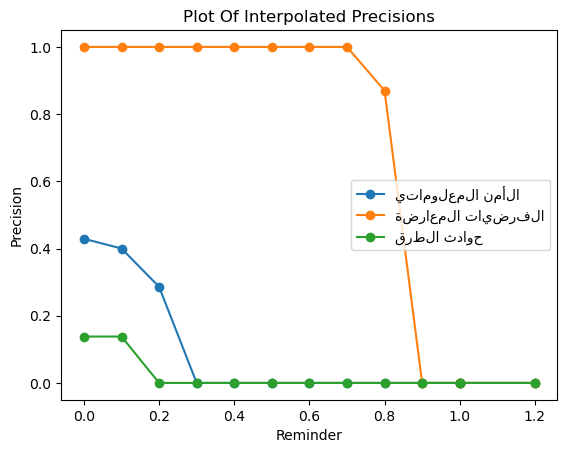

In [40]:
Plot(Dict_InterAWNV,QueryList)
Dict_InterAWNVdf=pd.DataFrame(Dict_InterAWNV,index=Dict_InterAWNV["Rappel"],columns=["PreInt "+QueryList[0],"PreInt "+QueryList[1],"PreInt "+QueryList[2]])
Dict_InterAWNVdf.to_excel('./PrecisionInterpoli/InterpoleReformulationEtValidation'+Modal+'.xlsx')

Calcul Precision au point

In [41]:
P5AWNV=Prec_Pos(ManuallyQueryFindAWNV,5)
P10AWNV=Prec_Pos(ManuallyQueryFindAWNV,10)
P15AWNV=Prec_Pos(ManuallyQueryFindAWNV,15)
P20AWNV=Prec_Pos(ManuallyQueryFindAWNV,20)

In [42]:
print("P5",P5AWNV)
print("P10",P10AWNV)
print("P15",P15AWNV)
print("P20",P20AWNV)

P5 {'الأمن المعلوماتي': [0.05], 'الفرضيات المعارضة': [1.0], 'حوادث الطرق': [0.0]}
P10 {'الأمن المعلوماتي': [0.141], 'الفرضيات المعارضة': [1.0], 'حوادث الطرق': [0.0]}
P15 {'الأمن المعلوماتي': [0.094], 'الفرضيات المعارضة': [1.0], 'حوادث الطرق': [0.004]}
P20 {'الأمن المعلوماتي': [0.071], 'الفرضيات المعارضة': [0.9], 'حوادث الطرق': [0.008]}


In [43]:
DFQ1=pd.DataFrame(ManuallyQueryFindAWNV[QueryList[0]],index=ManuallyQueryFindAWNV[QueryList[0]]["index"],columns=["File","pertinance","Reminder","Precision"])
DFQ1.to_excel("./DFQuery/DFRVQ1"+Modal+".xlsx")
DFQ2=pd.DataFrame(ManuallyQueryFindAWNV[QueryList[1]],index=ManuallyQueryFindAWNV[QueryList[1]]["index"],columns=["File","pertinance","Reminder","Precision"])
DFQ2.to_excel("./DFQuery/DFRVQ2"+Modal+".xlsx")
DFQ3=pd.DataFrame(ManuallyQueryFindAWNV[QueryList[2]],index=ManuallyQueryFindAWNV[QueryList[2]]["index"],columns=["File","pertinance","Reminder","Precision"])
DFQ3.to_excel("./DFQuery/DFRVQ3"+Modal+".xlsx")


-------------------------------------Conclusion -Tableaux récapitulatifs-------------------------------

In [44]:
Table1={"Requête":["Requête originale","Requête Reformulée automatique","Requête Reformulée automatique + validation de l'utilisateur"],
        "Mots de requête1":[QueryList[0],QueryAWN[0],QueryAWNV[0]],
        "Mots de requête2":[QueryList[1],QueryAWN[1],QueryAWNV[1]],
        "Mots de requête3":[QueryList[2],QueryAWN[2],QueryAWNV[2]],
}

Table1=pd.DataFrame(Table1,index=Table1['Requête'],columns=['Mots de requête1','Mots de requête2','Mots de requête3'])
Table1.to_excel('Table1.xlsx')

In [ ]:
Table2={"Mots":[],"Existe En AWN":[]}
for key,value in wordsv.items():
    Table2["Mots"].append(key)
    if len(value)>1:
        Table2["Existe En AWN"].append("Oui")
    else:
        Table2["Existe En AWN"].append("Non")
Table2=pd.DataFrame(Table2)
Table2.to_excel('Table2.xlsx',index=False)

Import xlsx File

In [ ]:
Results={"Rappel":[],"BM25F_SR":[],"Frequency_SR":[],"BM25F_R":[],"Frequency_R":[],"BM25F_RV":[],"Frequency_RV":[]}
Q1 = pd.read_excel(r'./working/ الأمن المعلوماتي.xlsx').set_index("Rappel")
Q2 = pd.read_excel(r'./working/حوادث الطرق.xlsx').set_index("Rappel")
Q3 = pd.read_excel(r'./working/الفرضيات المعارضة.xlsx').set_index("Rappel")


calculate Q1+Q2+Q3

In [ ]:

Results["Rappel"]=[index for index in Q1.index]
Results["BM25F_SR"]=[((Q1["BM25F_SR"][index]+Q2["BM25F_SR"][index]+Q3["BM25F_SR"][index])/3) for index in Q1.index ]
Results["Frequency_SR"]=[((Q1["Frequency_SR"][index]+Q2["Frequency_SR"][index]+Q3["Frequency_SR"][index])/3) for index in Q1.index ]
Results["BM25F_R"]=[((Q1["BM25F_R"][index]+Q2["BM25F_R"][index]+Q3["BM25F_R"][index])/3) for index in Q1.index ]
Results["Frequency_R"]=[((Q1["Frequency_R"][index]+Q2["Frequency_R"][index]+Q3["Frequency_R"][index])/3) for index in Q1.index ]
Results["BM25F_RV"]=[((Q1["BM25F_RV"][index]+Q2["BM25F_RV"][index]+Q3["BM25F_RV"][index])/3) for index in Q1.index ]
Results["Frequency_RV"]=[((Q1["Frequency_RV"][index]+Q2["Frequency_RV"][index]+Q3["Frequency_RV"][index])/3) for index in Q1.index ]

PreIn=pd.DataFrame(Results,index=Results["Rappel"],columns=["BM25F_SR","Frequency_SR","BM25F_R","Frequency_R","BM25F_RV","Frequency_RV"])
PreIn.to_excel('./Result/Précision Interpolée Q1+Q2+Q3.xlsx')